In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.unet import UNET, make_Jaccard_XEntropy_Loss
from data.make_dataset import load_train_images
from keras_contrib.losses.jaccard import jaccard_distance

Using TensorFlow backend.


In [2]:
train, val, y_train, y_val = load_train_images()

In [3]:
_, height, width, channel = train.shape
input_shape = (height, width, channel)

In [42]:
unet = UNET(input_shape,3,[4,8,16,32],3)

In [43]:
unet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 4)  40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 4)  148         conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 4)  0           conv2d_40[0][0]                  
____________________________________________________________________________________________

In [45]:
jaccard_xentropy = make_Jaccard_XEntropy_Loss(1.0)

In [46]:
unet.model.compile(optimizer='adam',loss=jaccard_xentropy,metrics=['accuracy'])

In [47]:
unet.model.fit(train,y_train,epochs=1,validation_data=(val,y_val),shuffle=True,batch_size=1)

Train on 669 samples, validate on 173 samples
Epoch 1/1
669/669 [==============================] - 162s 242ms/step - loss: 1.0912 - accuracy: 0.1793 - val_loss: 1.0890 - val_accuracy: 0.1782


In [48]:
preds = unet.model.predict(val,verbose=1)

173/173 [==============================] - 6s 32ms/step


In [49]:
preds.shape

(173, 256, 256, 3)

In [50]:
preds = preds.argmax(-1)

In [51]:
preds.shape

(173, 256, 256)

In [52]:
uniq, counts = np.unique(preds, return_counts=True)

In [53]:
counts/counts.sum()

array([0.17823465, 0.62345939, 0.19830596])

In [54]:
uniq

array([0, 1, 2])

In [55]:
uniq, counts = np.unique(y_val, return_counts=True)

In [56]:
counts/counts.sum()

array([0.93738975, 0.01963868, 0.04297157])

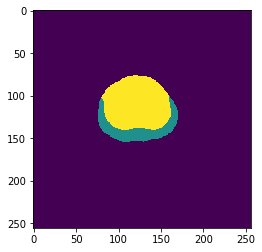

In [57]:
plt.imshow(y_val[11,:,:,0])

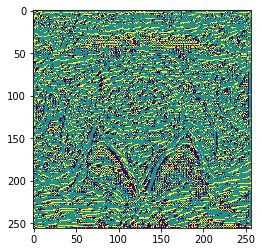

In [58]:
plt.imshow(preds[11,:,:])

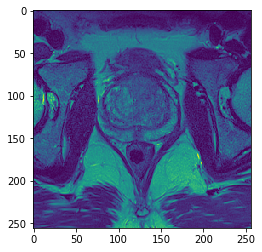

In [59]:
plt.imshow(val[11,:,:,0])